In [18]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import rdkit
import os 

import matplotlib.pyplot as plt

from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (LeaveOneOut, cross_val_predict,
                                     cross_val_score, train_test_split)

import numpy as np 

from rdkit.Chem import Descriptors
print(len(Descriptors._descList))
print(Descriptors._descList[:5])

print(rdkit.__version__)

208
[('MaxEStateIndex', <function MaxEStateIndex at 0x7fdbb1bff880>), ('MinEStateIndex', <function MinEStateIndex at 0x7fdbb1bff910>), ('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x7fdbb1bff9a0>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x7fdbb1bffa30>), ('qed', <function qed at 0x7fdbb1c3e9e0>)]
2022.03.5


In [19]:
molecules = []
fnames = []
lnames = []
labels = []

for dir in os.listdir('./data'):
    if os.path.isdir('./data/'+dir):
        for file in os.listdir('./data/'+dir):
            if file.endswith('.pdb'):
                m = rdkit.Chem.rdmolfiles.MolFromPDBFile('./data/'+dir+"/"+file)
                if m is None:
                    print("Error reading file:", file)
                else:
                    molecules.append(m)
                    fnames.append(dir.rstrip().lstrip())

fp = open('./data/labels.txt', 'r')

for line in fp:
    sline = line.rstrip().lstrip().split()
    lnames.append(sline[1])
    labels.append(float(sline[-1]))

fp.close()

fingersize = 64
rdgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=fingersize)

np_bits_l = []
np_counts_l = []
moldescriptors = []

for m in molecules:
    np_bits = rdgen.GetFingerprintAsNumPy(m)
    np_bits_l.append(np_bits)
    np_counts = rdgen.GetCountFingerprintAsNumPy(m)
    np_counts_l.append(np_counts)

    res = {}
    missingVal=None
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(m)
        except:
            # print the error message:
            #import traceback
            #traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal

        res[nm] = val

    moldescriptors.append(res)

# need to add charge and spin to the descriptors
chargespin = {}
for dir in os.listdir('./data'):
    if os.path.isdir('./data/'+dir):

        if os.path.isfile("./data/"+dir+"/.CHRG") and \
            os.path.isfile("./data/"+dir+"/.UHF"):
        
            fp = open("./data/"+dir+"/.CHRG", "r")
            charge = float(fp.readline().rstrip().lstrip())
            fp.close()
            fp = open("./data/"+dir+"/.UHF", "r")
            spin = float(fp.readline().rstrip().lstrip())
            fp.close()
            chargespin[dir] = [charge, spin]

for i, molname in enumerate(fnames):
    if molname in chargespin:
        moldescriptors[i]["Charge"] = chargespin[molname][0]
        moldescriptors[i]["Spin"] = chargespin[molname][1]
    else:
        moldescriptors[i]["Charge"] = 0.0
        moldescriptors[i]["Spin"] = 0.0

for i in range(len(moldescriptors)):
    for k,v in moldescriptors[i].items():
        if v is None:
            moldescriptors[i][k] = 0.0
        elif v is np.nan:   
            moldescriptors[i][k] = 0.0 

Error reading file: struc.pdb


[12:41:31] WARNING: not removing hydrogen atom without neighbors
[12:41:31] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[12:41:31] WARNING: not removing hydrogen atom without neighbors
[12:41:31] WARNING: not removing hydrogen atom without neighbors
[12:41:31] 

****
Invariant Violation
Bond order must be Single, Double, Triple or Aromatic
Violation occurred on line 59 in file /home/conda/feedstock_root/build_artifacts/rdkit_1660289032136/work/Code/GraphMol/Descriptors/BCUT.cpp
Failed Expression: 0
****

[12:41:31] 

****
Invariant Violation
Bond order must be Single, Double, Triple or Aromatic
Violation occurred on line 59 in file /home/conda/feedstock_root/build_artifacts/rdkit_1660289032136/work/Code/GraphMol/Descriptors/BCUT.cpp
Failed Expression: 0
****

[12:41:31] 

****
Invariant Violation
Bond order must be Single, Double, Triple or Aromatic
Violation occurred on line 59 in file /home/conda/feedstock_root/build_artifacts/rdkit_1660289032136/work/Code/GraphMol

In [21]:
moldescriptors_featues = []
Y = []
names = []

s_fnames = set(fnames)
s_lnames = set(lnames)
s_int = s_fnames.intersection(s_lnames)
for molname in s_int:
    #get index of molname in fnames
    idx = fnames.index(molname)
    #np_bits_features.append(np_bits_l[idx])
    #np_counts_features.append(np_counts_l[idx])
    val = [i for i in moldescriptors[idx].values()]
    val.extend(np_counts_l[idx])
    moldescriptors_featues.append(val)
    #get index of molname in lnames
    idx2 = lnames.index(molname)
    Y.append(labels[idx2])
    
    names.append(molname)

Y = np.array(Y)
moldescriptors_featues = np.array(moldescriptors_featues)
moldescriptors_featues = np.nan_to_num(moldescriptors_featues, 0.0)

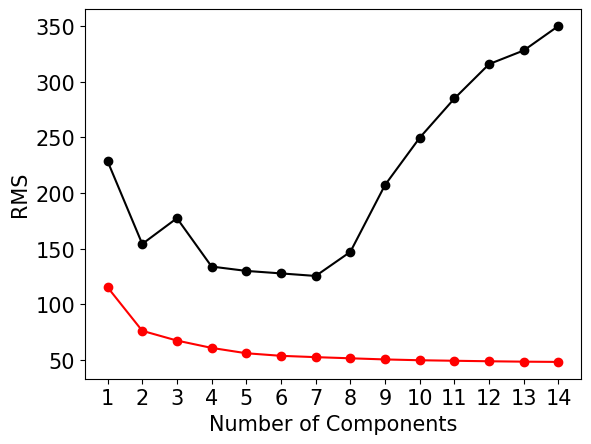

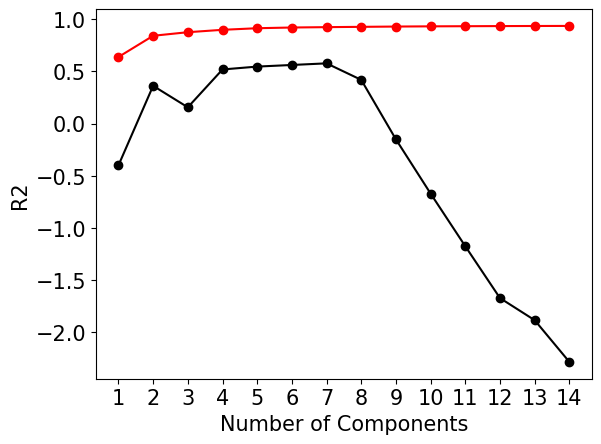

In [22]:
import models
%reload_ext models


perc_split = 0.2
models.pls_model (0.2, moldescriptors_featues, Y)

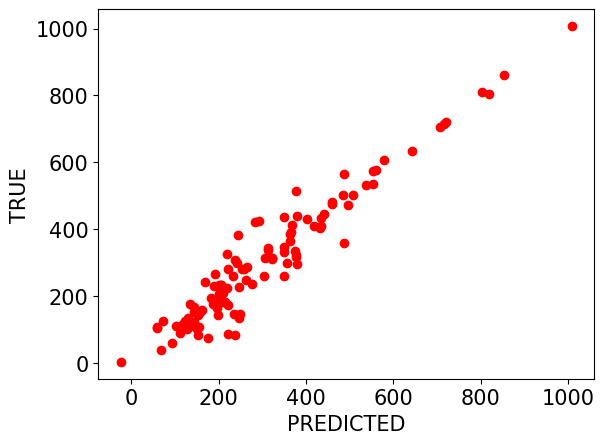

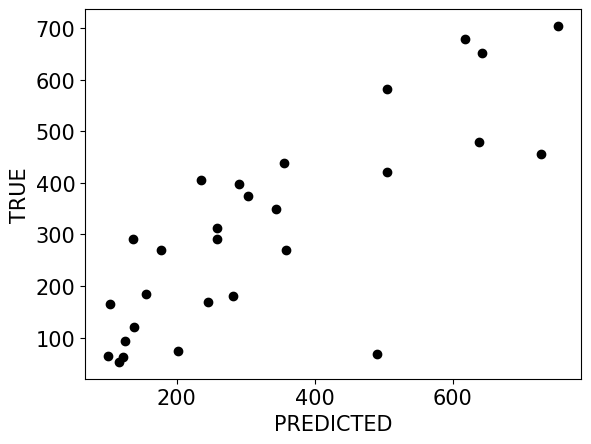

In [23]:
perc_split = 0.2
models.pls_model (0.2, moldescriptors_featues, Y, False, 7)

In [24]:
%reload_ext models

perc_split = 0.2

min_train_mse_hyper, min_test_mse_hyper, max_train_r2_hyper, max_test_r2_hyper = \
    models.rf_model (0.2, moldescriptors_featues, Y)

In [ ]:

for d in [min_train_mse_hyper, min_test_mse_hyper, max_train_r2_hyper, max_test_r2_hyper]:
    perc_split = 0.2
    models.rf_model (0.2, moldescriptors_featues, Y, False, [d['n_estimators']], \
                     [d['max_depth']], [d['min_samples_split']], \
                         [d['min_samples_leaf']], [d['random_state']], \
                             [d['bootstrap']], [d['max_features']])
